In [21]:
import os
import cv2
import numpy as np
import torch
import RRDBNet_arch as arch
from skimage.metrics import structural_similarity as ssim
from math import log10


In [22]:
# Load the ESRGAN model
model_path = 'models/RRDB_ESRGAN_x4.pth'
device = torch.device('cpu')  # Use 'cuda' for GPU if available

model = arch.RRDBNet(3, 3, 64, 23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(device)


C:\Users\HP\AppData\Local\Temp\ipykernel_14964\1924132286.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path), strict=True)


In [23]:
# Directories for test images
test_LR_dir = 'LR'
results_dir = 'results'  # This is where your converted images (HR) are located

# Metrics initialization
psnr_values = []
ssim_values = []


In [24]:
# Helper function for PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * log10(255.0 / np.sqrt(mse))


In [32]:
# Iterate over test images
for filename in os.listdir(test_LR_dir):
    lr_path = os.path.join(test_LR_dir, filename)
    
    # Construct the HR path by adding '_rlt' before the extension and changing it to .png
    hr_filename = os.path.splitext(filename)[0] + '_rlt.png'
    hr_path = os.path.join(results_dir, hr_filename)

    if not os.path.exists(hr_path):
        print(f"High-resolution counterpart not found for {filename}")
        continue

    # Load LR image
    img_LR = cv2.imread(lr_path)
    img_LR = img_LR * 1.0 / 255
    img_LR = torch.from_numpy(np.transpose(img_LR[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img_LR.unsqueeze(0).to(device)

    # Generate SR image
    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))  # Convert to BGR
    output = (output * 255.0).round().astype(np.uint8)

    # Load HR image
    img_HR = cv2.imread(hr_path)
    img_HR = cv2.cvtColor(img_HR, cv2.COLOR_BGR2RGB)

    # Compute PSNR and SSIM
    psnr = calculate_psnr(output, img_HR)
    ssim_value = ssim(output, img_HR, multichannel=True, data_range=255, win_size=3, channel_axis=-1)

    psnr_values.append(psnr)
    ssim_values.append(ssim_value)

print(f"{filename}: PSNR={psnr:.2f}, SSIM={ssim_value:.4f}")

comic.png: PSNR=30.43, SSIM=0.8307


In [34]:
# Print average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
print(f"\nAverage PSNR: {average_psnr:.2f}")
print(f"Average SSIM: {average_ssim:.4f}")



Average PSNR: 30.06
Average SSIM: 0.8511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


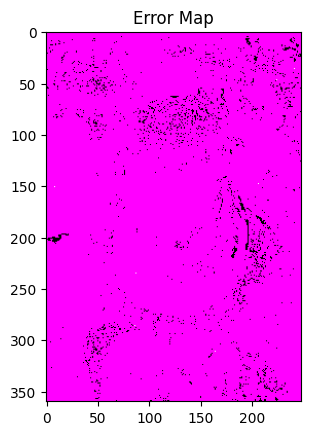

In [39]:
import matplotlib.pyplot as plt

# Compute error map
error_map = np.abs(output.astype(np.float32) - img_HR.astype(np.float32))

# Plot the error map (difference image)
plt.imshow(error_map)
plt.title("Error Map")
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Example: Define a quality threshold for PSNR (e.g., good vs bad quality)
psnr_threshold = 30  # Above 30 is considered good quality

# Initialize lists for predicted and true labels
true_labels = []  # Actual labels (e.g., 1 for good quality, 0 for low quality)
predicted_labels = []  # Predicted labels based on PSNR threshold

# Iterate over your images and calculate the PSNR
for filename in os.listdir(test_LR_dir):
    # Load the images (same as before)
    # ...
    psnr = calculate_psnr(output, img_HR)
    
    # Define labels based on PSNR threshold
    true_label = 1 if psnr >= 30 else 0  # 1 for good quality, 0 for low quality
    predicted_label = 1 if psnr >= 30 else 0  # Same here for predicted

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[20]]


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
